In [1]:
import scipy.io
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq


In [2]:
playback_44100 = scipy.io.loadmat('./data/playback_44100.mat')['w441'].reshape(-1)

playback_44100 = playback_44100[44100:44100*2]

print("len playback_44100 :", len(playback_44100))

fs_out = 48_000

fs_in = 44_100

# playback_48000 = signal.resample(playback_44100, int(len(playback_44100) * freq_target / 44_100))

len playback_44100 : 44100


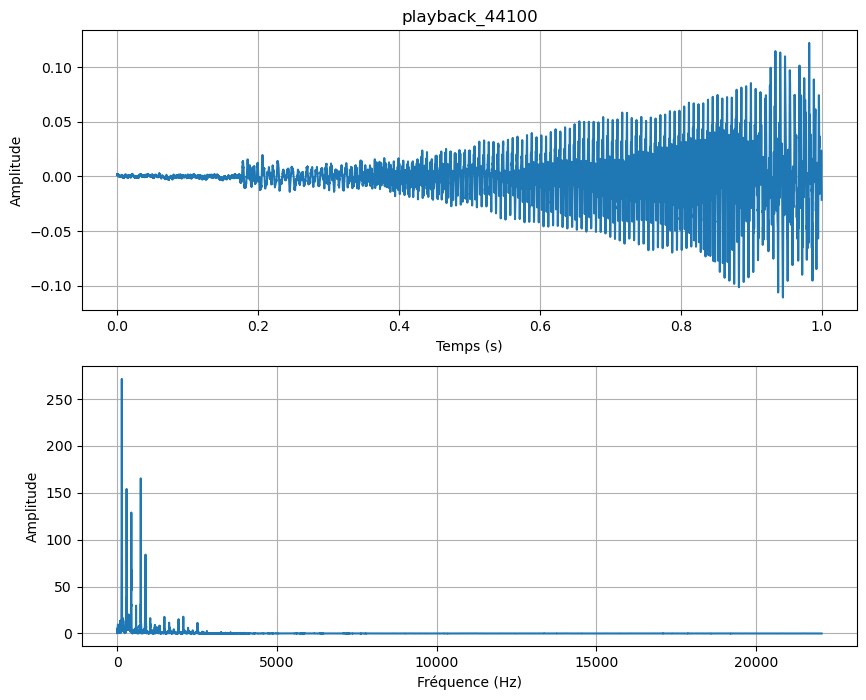

In [3]:
def plot_signal(signal, freq, title):
    
    t = np.arange(0, len(signal)/freq, 1/freq)
    
    signal_fft = rfft(signal)
    signal_freq = rfftfreq(len(signal), 1/freq)
    
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, signal)
    plt.title(title)
    plt.grid()
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    
    
    plt.subplot(2, 1, 2)
    plt.plot(signal_freq, np.abs(signal_fft))
    # plt.title(title)
    plt.grid()
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude")

plot_signal(playback_44100, fs_in,  "playback_44100")  



In [4]:
factor = np.gcd(fs_in, fs_out)

up_factor = fs_out // factor
down_factor = fs_in // factor

print("up_factor :", up_factor)
print("down_factor :", down_factor)

up_factor : 160
down_factor : 147


In [5]:


print("Le plus grand commun diviseur de 44100 et 48000 est :", np.gcd(fs_in, fs_out))

def UpSample(signal, factor):
    upsampled = np.zeros(len(signal) * factor)
    upsampled[::factor] = signal
    return upsampled

def DownSample(signal, factor):
    return signal[::factor]


Le plus grand commun diviseur de 44100 et 48000 est : 300


Text(0.5, 0, 'Fréquence (rad/sample)')

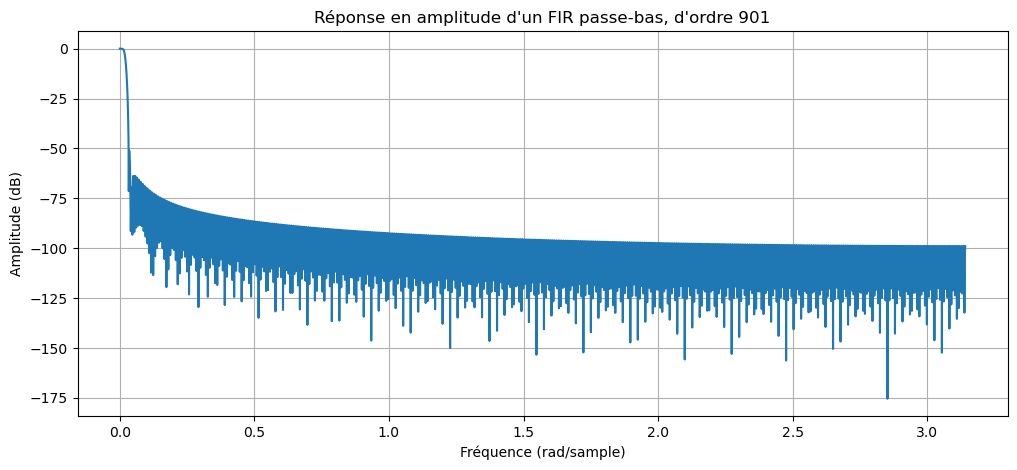

In [6]:


cutoff = 1/down_factor

taps = signal.firwin(numtaps=901, cutoff=cutoff)

# Diagramme de Bode
w, h = signal.freqz(taps, worN=8000)
plt.figure(figsize=(12, 5))
plt.plot(w, 20*np.log10(np.abs(h)))
plt.grid()
plt.title("Réponse en amplitude d'un FIR passe-bas, d'ordre 901")
plt.ylabel("Amplitude (dB)")
plt.xlabel("Fréquence (rad/sample)")

Text(0, 0.5, 'Amplitude')

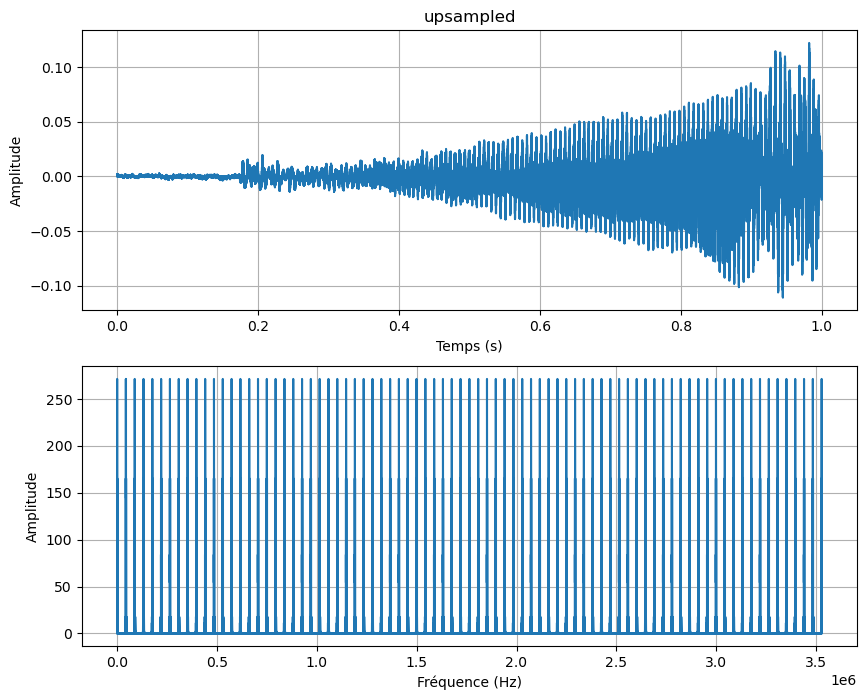

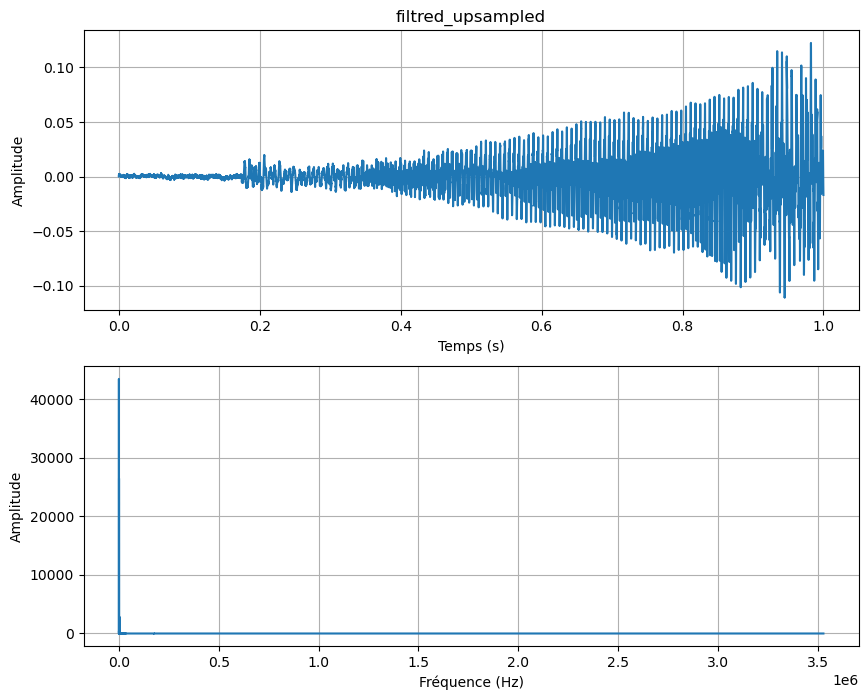

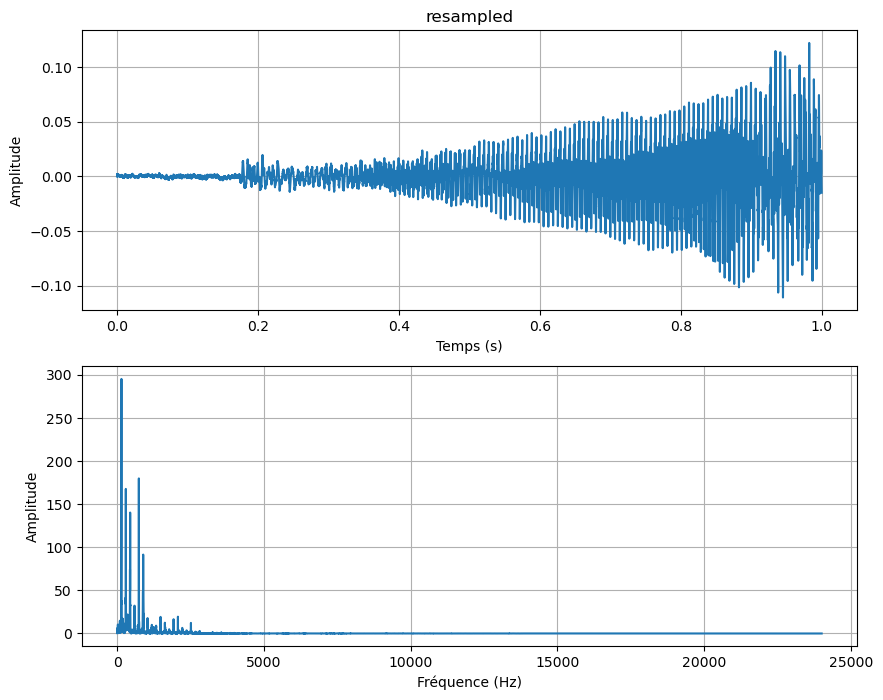

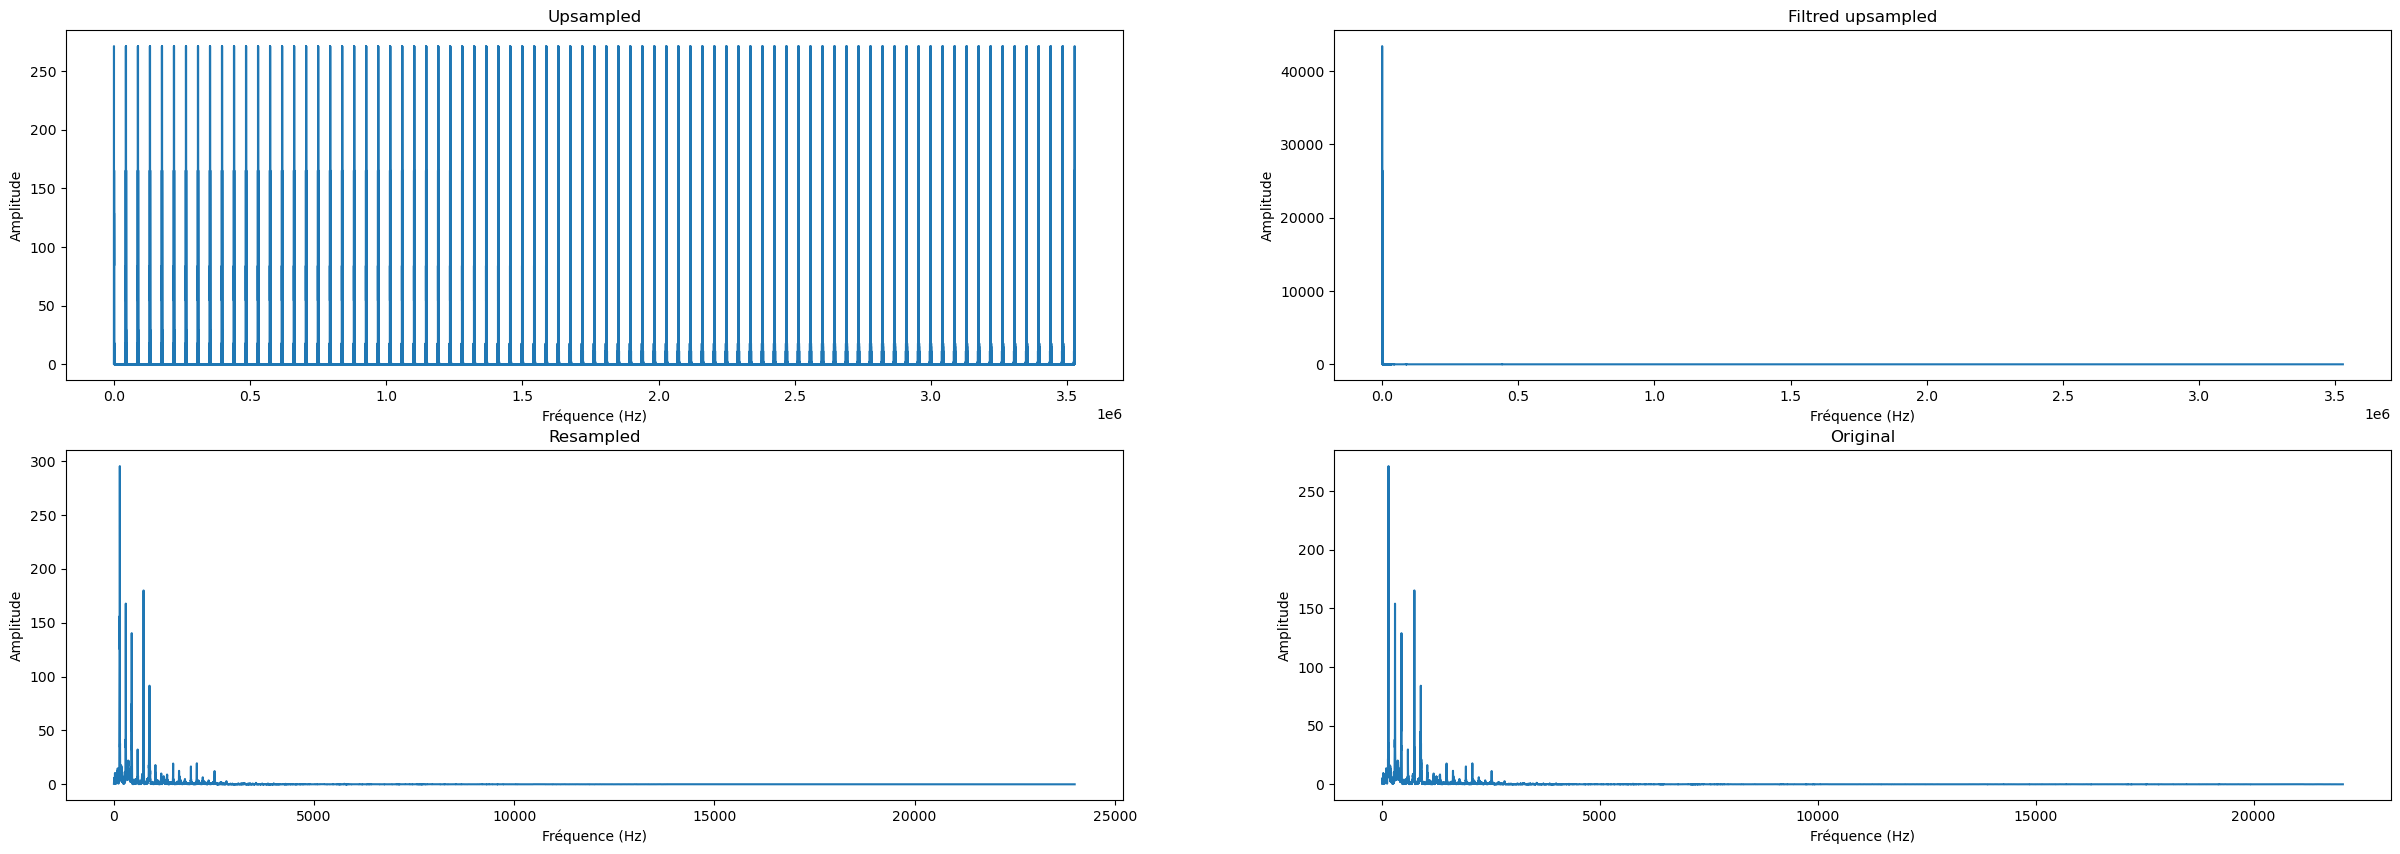

In [21]:


upsampled = UpSample(playback_44100, up_factor)


plot_signal(upsampled, fs_in*up_factor, "upsampled")



cutoff = 1/down_factor
taps = signal.firwin(numtaps=901, cutoff=cutoff)

filtred_upsampled = signal.lfilter(taps, 1.0, upsampled)*up_factor


plot_signal(filtred_upsampled, fs_in*up_factor, "filtred_upsampled")

resampled = DownSample(filtred_upsampled, down_factor)

plot_signal(resampled, fs_out, "resampled")

plt.figure(figsize=(15*2, 5*2))

plt.subplot(2, 2, 1)
plt.plot(rfftfreq(len(upsampled), 1/fs_in/up_factor), np.abs(rfft(upsampled)))
plt.title("Upsampled")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 2)
plt.plot(rfftfreq(len(filtred_upsampled), 1/fs_in/up_factor), np.abs(rfft(filtred_upsampled)))
plt.title("Filtred upsampled")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 3)
plt.plot(rfftfreq(len(resampled), 1/fs_out), np.abs(rfft(resampled)))
plt.title("Resampled")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 4)
plt.plot(rfftfreq(len(playback_44100), 1/fs_in), np.abs(rfft(playback_44100)))
plt.title("Original")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")


In [38]:
def NaiveResample(s, fs_in, fs_out, numtaps=901):
    
    gcd = np.gcd(fs_in, fs_out)
    
    upsampled = UpSample(s, fs_out // gcd)
    
    cutoff = 1/(2 *fs_in // gcd)
    
    taps = signal.firwin(numtaps=numtaps, cutoff=cutoff)
    
    filtred_upsampled = signal.lfilter(taps, 1.0, upsampled)*(fs_out // gcd)
    
    resampled = DownSample(filtred_upsampled, fs_in // gcd)
    
    return resampled




len original_fft : 22051
len resampled_fft : 22051
Erreur quadratique moyenne entre le spectre initial et le spectre resamplé : 0.0010112443449826465


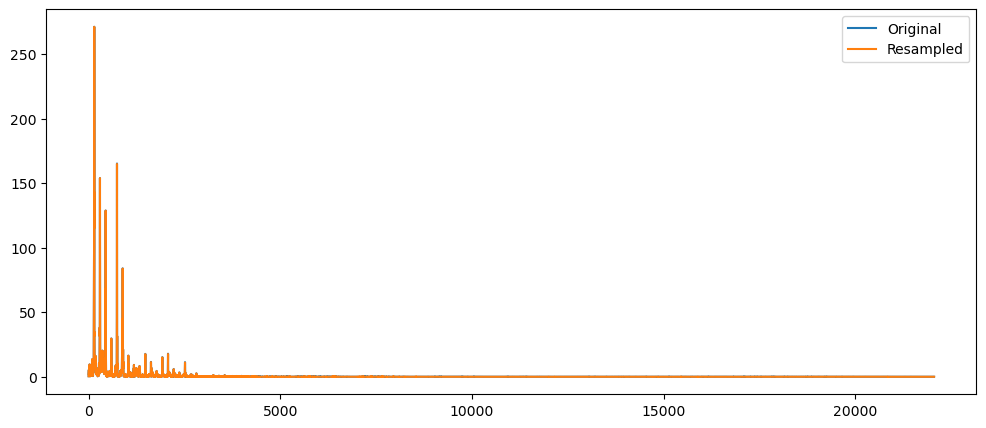

In [39]:
from scipy.interpolate import interp1d

def calculate_spectrum_error(original_signal, resampled_signal, fs_original, fs_resampled):
    # Calculer les FFT des signaux
    original_fft = np.abs(rfft(original_signal))
    resampled_fft = np.abs(rfft(resampled_signal))[:len(original_fft)]/fs_resampled*fs_original
    
    print("len original_fft :", len(original_fft))
    print("len resampled_fft :", len(resampled_fft))
    
    plt.figure(figsize=(12, 5))
    plt.plot( original_fft, label="Original")
    plt.plot( resampled_fft, label="Resampled")
    plt.legend()
    
    
    # Calculer l'erreur quadratique moyenne (MSE)
    mse = np.mean((original_fft - resampled_fft[:len(original_fft)]) ** 2)
    
    return mse

resampled = NaiveResample(playback_44100, fs_in, fs_out)

# Calculer l'erreur entre le spectre initial et le spectre resamplé
error = calculate_spectrum_error(playback_44100, resampled, fs_in, fs_out)
print("Erreur quadratique moyenne entre le spectre initial et le spectre resamplé :", error)

## Filtre en cascade

Text(0.5, 1.0, 'Réponse en amplitude')

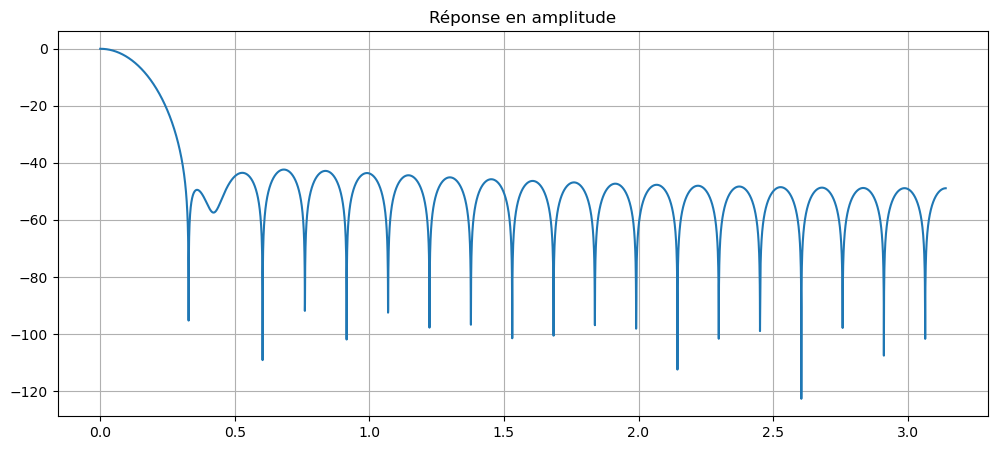

In [43]:


cutoff = 1/down_factor

taps = signal.firwin(numtaps=41, cutoff=cutoff)

# Diagramme de Bode
w, h = signal.freqz(taps, worN=8000)
plt.figure(figsize=(12, 5))
plt.plot(w, 20*np.log10(np.abs(h)))
plt.grid()
plt.title("Réponse en amplitude")

up_factors : [2, 2, 2, 2, 2, 5]
down_factors : [3, 7, 7]


<Figure size 1500x1000 with 0 Axes>

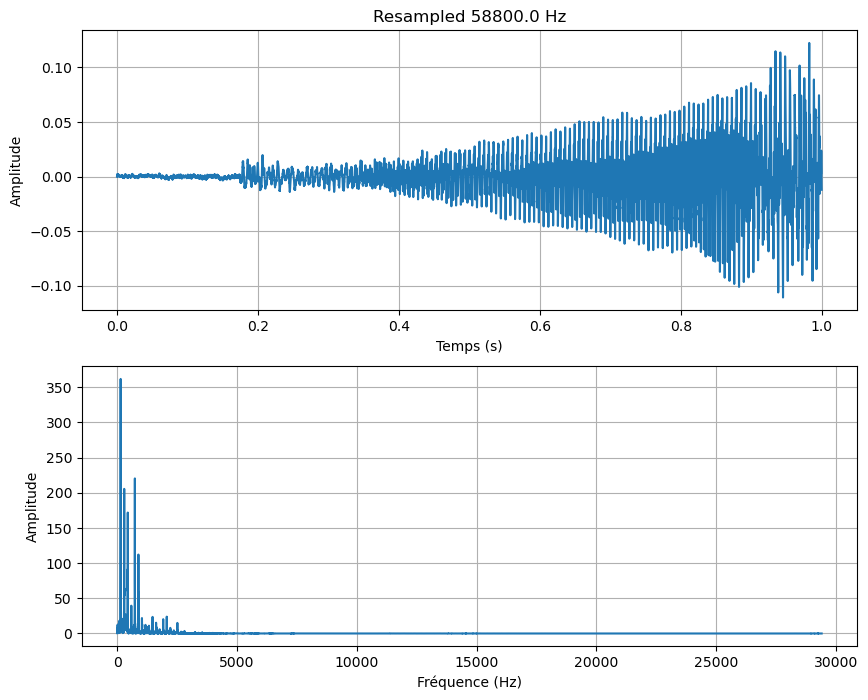

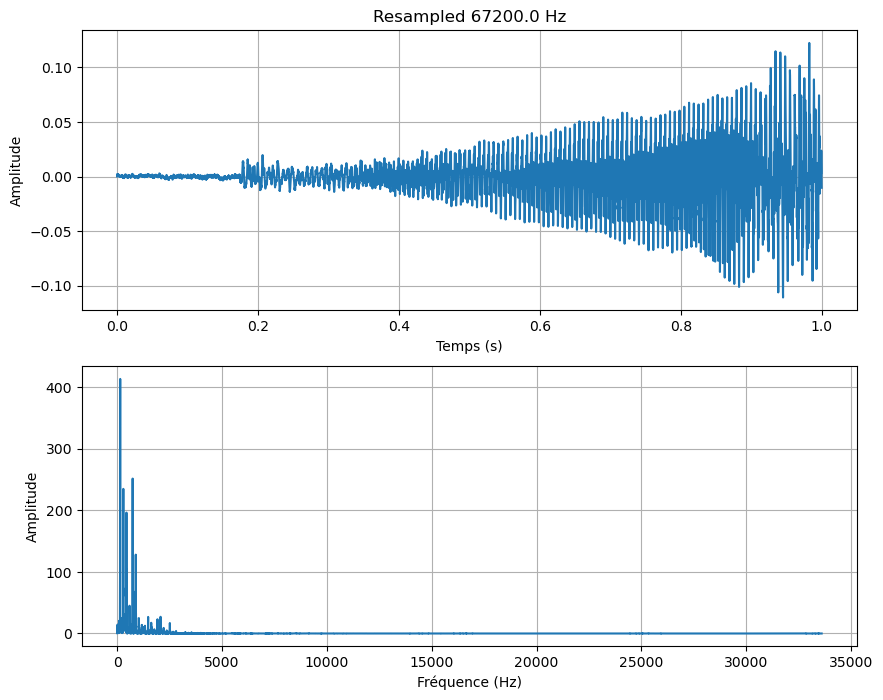

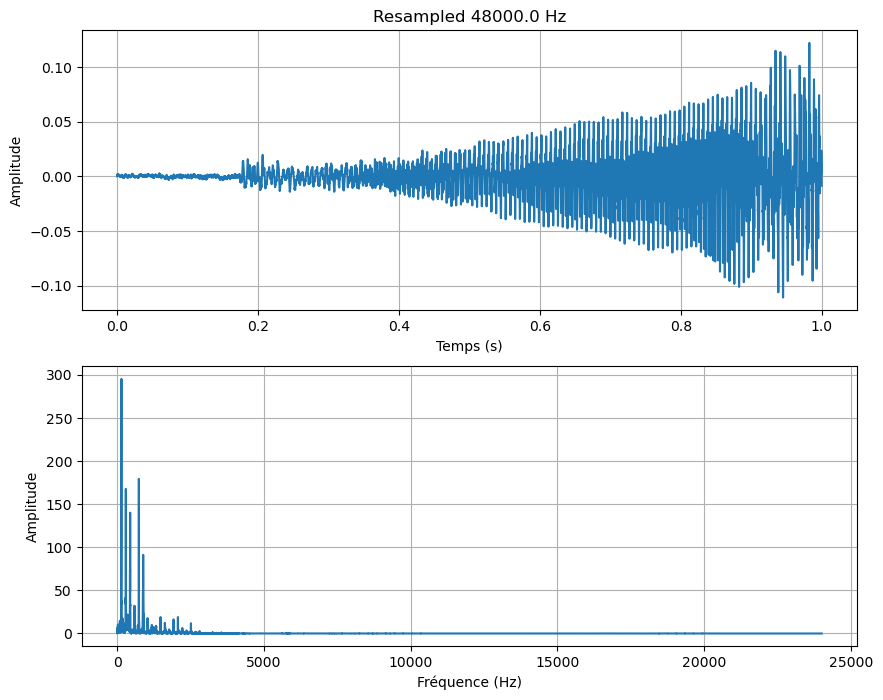

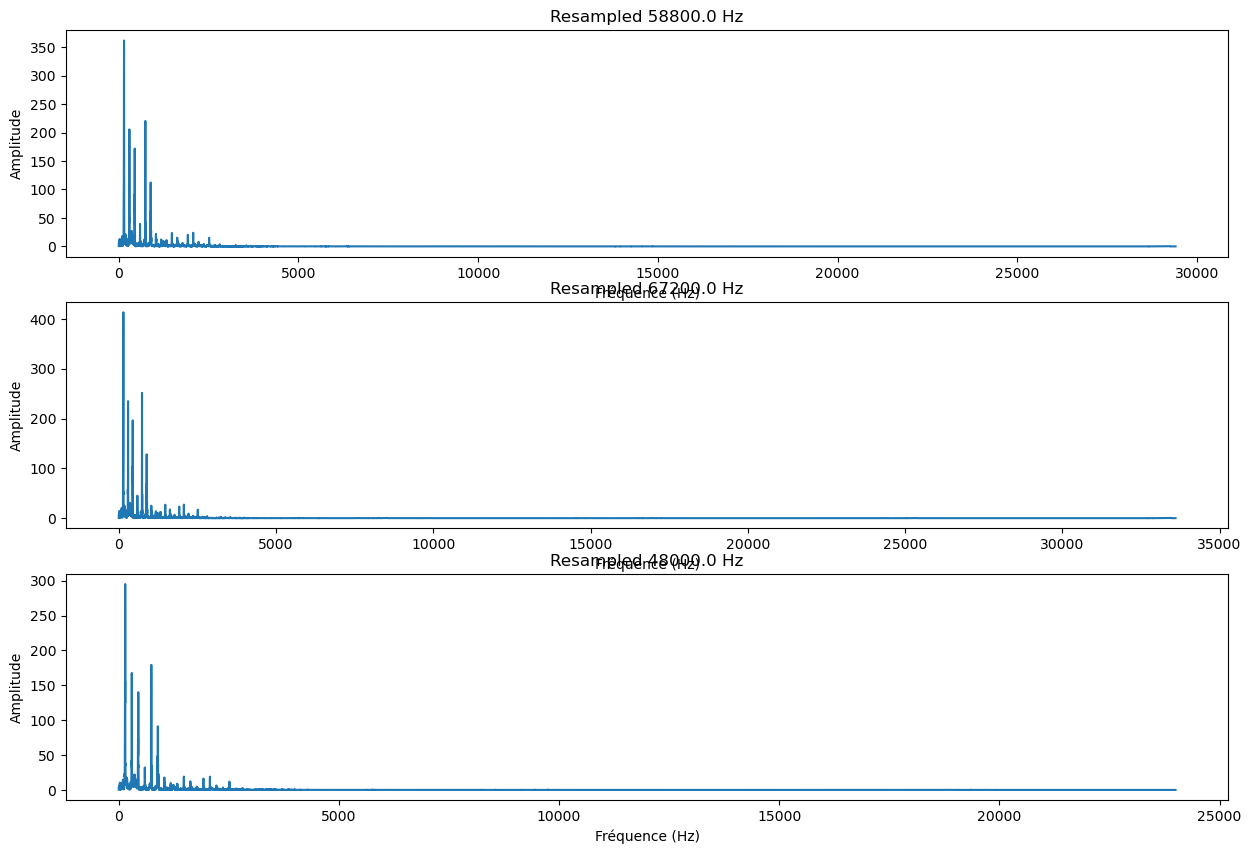

In [59]:
from sympy import factorint

gcd = np.gcd(fs_in, fs_out)

up_factor = fs_out // gcd
down_factor = fs_in // gcd

# Décomposition des facteurs en nombres premiers
up_factors = factorint(up_factor, multiple=True)
down_factors = factorint(down_factor, multiple=True)

print("up_factors :", up_factors)
print("down_factors :", down_factors)

factors = [(4, 3), (8, 7), (5, 7)]

order = 41

x = playback_44100

points_per_hz = len(x) / fs_in

freq = fs_in

x_s = []

plt.figure(figsize=(15, 10))

for i, factor in enumerate(factors):
    up_factor, down_factor = factor
    x = UpSample(x, up_factor)
    cutoff = 1/(2*down_factor)
    taps = signal.firwin(numtaps=order, cutoff=cutoff)
    x = signal.lfilter(taps, 1.0, x)*up_factor
    x = DownSample(x, down_factor)
    x_s.append(x)
    freq = len(x) / points_per_hz
    plot_signal(x, freq, f"Resampled {freq} Hz")
    
plt.show()

resampled = x
    
plt.figure(figsize=(15, 10))
for i, x in enumerate(x_s):
    freq = len(x) / points_per_hz
    plt.subplot(3, 1, i + 1)
    plt.plot(rfftfreq(len(x), 1/freq), np.abs(rfft(x)))
    plt.title(f"Resampled {freq} Hz")
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude")

plt.show()

In [ ]:
def Resemple(x, factors, order=41):
    for i, factor in enumerate(factors):
        up_factor, down_factor = factor
        x = UpSample(x, up_factor)
        cutoff = 1/(2*down_factor)
        taps = signal.firwin(numtaps=order, cutoff=cutoff)
        x = signal.lfilter(taps, 1.0, x)*up_factor
        x = DownSample(x, down_factor)
    return x

len original_fft : 22051
len resampled_fft : 22051
Erreur quadratique moyenne entre le spectre initial et le spectre resamplé : 0.0015817595323121489


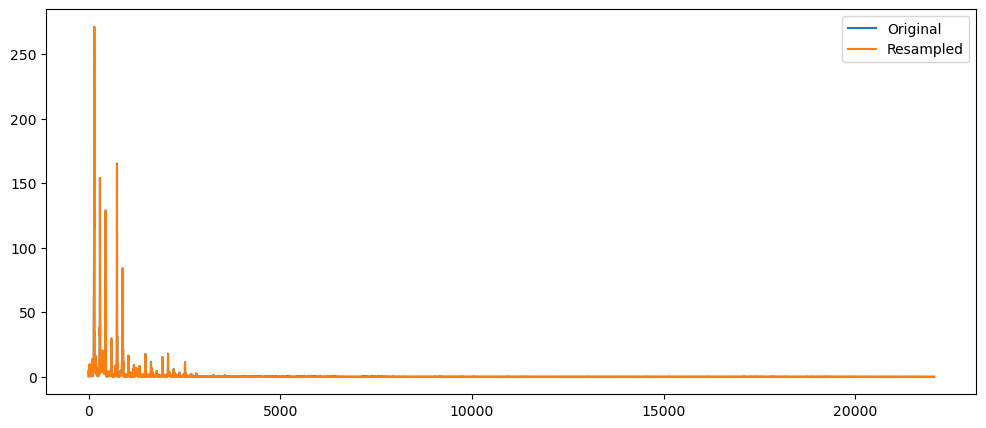

In [83]:
resampled = Resemple(playback_44100, factors, order=31)

# Calculer l'erreur entre le spectre initial et le spectre resamplé
error = calculate_spectrum_error(playback_44100, resampled, fs_in, fs_out)
print("Erreur quadratique moyenne entre le spectre initial et le spectre resamplé :", error)

In [85]:
%timeit -n 100 -r 10 Resemple(playback_44100, factors, order=31)

40.7 ms ± 3.36 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [84]:
%timeit -n 10 -r 10 Resemple(playback_44100, factors, order=31)

41.6 ms ± 5.63 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [67]:
%timeit -n 5 -r 5 NaiveResample(playback_44100, fs_in, fs_out)

1.64 s ± 45.4 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
